### This notebook presents visual comparison between KD-Tree vs Ball-Tree vs Brute-Force performances

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from functools import partial
from tqdm.notebook import tqdm
from IPython.display import set_matplotlib_formats

from src.kdtree import KDTreeOptimizer
from src.balltree import BallTreeOptimizer
from src.bruteforce import LinearOptimizer

In [2]:
USE_SVG = False
if USE_SVG:
    set_matplotlib_formats('svg')
np.random.seed(42)
plt.rcParams["savefig.dpi"] = 1000

First of all, this snippet below will perform model testing to verify that all three implementations produce the same output

In [3]:
n = 1000
nq = 5
d = 4
k = 3
l = 7

X = np.random.randn(n, d)
Xq = X[np.random.randint(0, len(X), nq)] + 0.01 * np.random.randn(nq, d)

optimizers = [LinearOptimizer, BallTreeOptimizer, KDTreeOptimizer]
results = []

for model in optimizers:
    params = {'X': X}
        
    try:
        opt = model(X, leaf_size=l)
    except TypeError:
        opt = model(X)
        
    res = opt.query(Xq, k=k)
    results.append(res)

for i in range(len(results)-1):
    assert np.all(np.sort(results[i], axis=-1)) == np.all(np.sort(results[i+1], axis=-1))
else:
    print('OK')

OK


Seems that we can proceed, so here is the implementation of function to generate data points.  
This function accepts number of points to generate and data dimensionality as well.  
In addition, we'll generate two types of data points because we expect different performance depending on data distribution.  
1. The first data distribution type will be sampled from standard normal distribution;
2. The second data distribution type will have only two meaningful dimensions that outline sine wave with noise,   
   but all the other features (independently of their count) will be just a small noise.

In [4]:
def generate_X_x(n, d, dummy=False):
    if dummy:
        space = np.linspace(0, 2*np.pi, n)[:,np.newaxis]
        ls = [space, 2*np.sin(space)]
        for _ in range(d - 2):
            ls.append(np.repeat(0, len(space))[:, np.newaxis])

        X = np.hstack(ls) + 0.05 * np.random.randn(n, d)
    else:
        X = np.random.randn(n, d)
        
    x = X[np.random.randint(0, len(X), 1)] + 0.01 * np.random.randn(1, d)
    return X, x

Example data demonstration in 2D

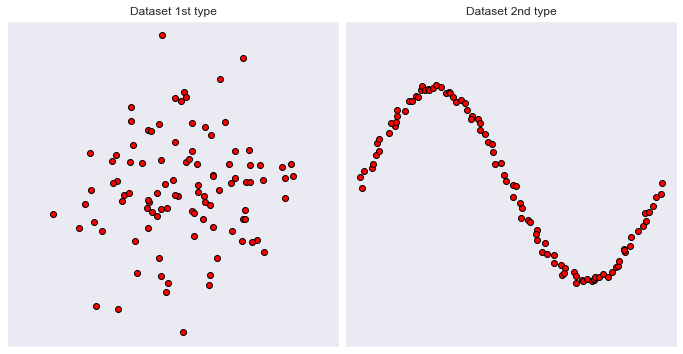

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), gridspec_kw={'wspace':0.02})

X, x = generate_X_x(100, 2, dummy=False)
ax[0].scatter(X[:,0], X[:,1], color='red', edgecolor='black')
ax[0].set_title('Dataset 1st type')

X, x = generate_X_x(100, 2, dummy=True)
ax[1].scatter(X[:,0], X[:,1], color='red', edgecolor='black')
ax[1].set_title('Dataset 2nd type')

ax[0].axis('equal')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].axis('equal')
ax[1].set_xticks([])
ax[1].set_yticks([])

fig.savefig('figures/datasets.png')

Here is also an implementation of functonality to measure performance and plotting charts.

In [6]:
def measure_param_space(optimizer, ns, ds, ks, ls, 
                        data_generator, n_runs=5, n_repeats=10):
    stats = []
    for n in tqdm(ns):
        for d in ds: 
            for k in ks:
                for l in ls:
                    ts = []
                    for _ in range(n_runs):
                        X, Xq = data_generator(n, d)
                        try:
                            opt = optimizer(X, leaf_size=l)
                        except TypeError:
                            opt = optimizer(X)
                        for _ in range(n_repeats):
                            t0 = time.perf_counter()
                            idx = opt.query(Xq, k=k)
                            t1 = time.perf_counter()
                            t = t1 - t0

                            ts.append(t)
                        
                    stats.append({'n': n, 'd': d, 'k': k, 'l': l, 't': np.median(ts), 's': np.std(ts)})

    return pd.DataFrame(stats)


def test_across(optimizer, ns, var_name, var_vals, var_default, 
                dummy_features=False, style='curves', ax=None, cmap=None):
    params = {'ns': ns, 'ds': [var_default['d']], 'ks': [var_default['k']], 'ls': [var_default['l']], var_name: var_vals}
    data_generator = partial(generate_X_x, dummy=dummy_features)
    n_runs = 5
    n_repeats = 10
    df = measure_param_space(optimizer, data_generator=data_generator, 
                             n_runs=n_runs, n_repeats=n_repeats, **params)

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))
            
    if style == 'curves':
        cmap = plt.get_cmap(cmap or 'Blues')
        level_colors = np.linspace(0.4, 0.8, len(var_vals))

        for i, val in enumerate(var_vals):
            fill_color = cmap(level_colors[i])
            df_sub = df[df[var_name[:-1]] == val]
            ax.plot(df_sub.n, df_sub.t, '-o', color=fill_color, label=val)
        ax.legend(title=var_names[var_name[:-1]], fancybox=True, loc='upper left')
        ax.set_ylabel(f'Median time (sec) over {n_repeats} trials')
        
    elif style == 'heatmap':
        pivot = df.pivot(var_name[:-1], 'n', values='t')

        sns.heatmap(pivot * 1000, square=True, annot=True, cbar=False, ax=ax)
        ax.set_ylabel(var_names[var_name[:-1]])
        
    ax.set_xlabel(var_names['n'])
    
    return ax

Now, we almost ready to perform tests. Since we have many parameters to test across (number of points, dimensionality, number of neighbors, leaf size) that cannot be displayed on one chart, we'll test the most interesting and reasonable pairs of parameters. For other variables that are not used in a perticular test, we will assume their default values. Here we define the following default values.
* Number of points - 1,000;
* Dimensionality - 4;
* Number of neighbors - 1;
* Leaf size - 30.

In [7]:
var_default = {
    'n': 1000,
    'd': 4,
    'k': 1,
    'l': 30
}

var_names = {
    'd': 'Dimensionality',
    'k': 'Number of neighbors',
    'l': 'Leaf size',
    'n': 'Number of points'
}

Also, in most cases we'll test across number of points, so here is the tabulation we'll use:

In [8]:
ns = np.logspace(start=6, stop=13, num=13-6+1, base=2, dtype='int')
ns

array([  64,  128,  256,  512, 1024, 2048, 4096, 8192])

### 1. Test dimationality impact

In [9]:
# tabulation values
ds = np.logspace(start=1, stop=9, num=9-1+1, base=2, dtype='int')[::2]
ds

array([  2,   8,  32, 128, 512])

Dataset type 1

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

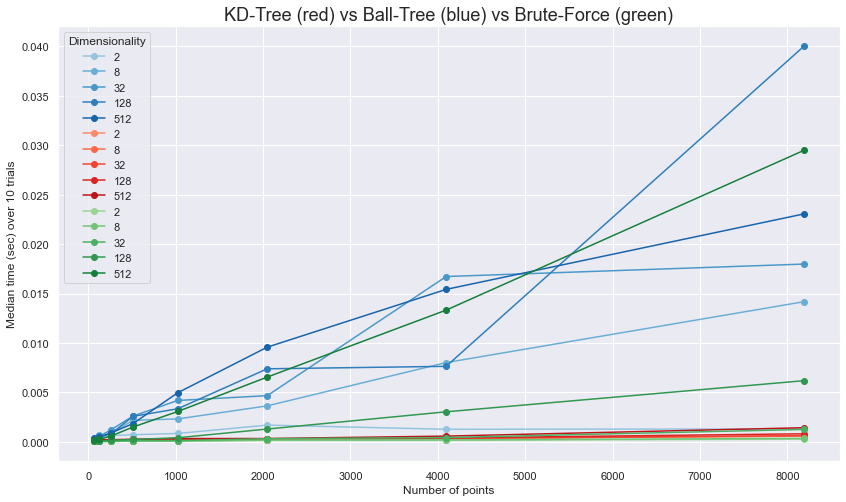

In [10]:
dummy_features = False
ax = test_across(BallTreeOptimizer, ns, 'ds', ds, var_default, dummy_features=dummy_features, cmap='Blues')
ax = test_across(KDTreeOptimizer, ns, 'ds', ds, var_default, dummy_features=dummy_features, ax=ax, cmap='Reds')
test_across(LinearOptimizer, ns, 'ds', ds, var_default, dummy_features=dummy_features, ax=ax, cmap='Greens')
ax.set_title(f'KD-Tree (red) vs Ball-Tree (blue) vs Brute-Force (green)', size=18);
plt.savefig('figures/variable=dimension;datset=1;chart=line.png');

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

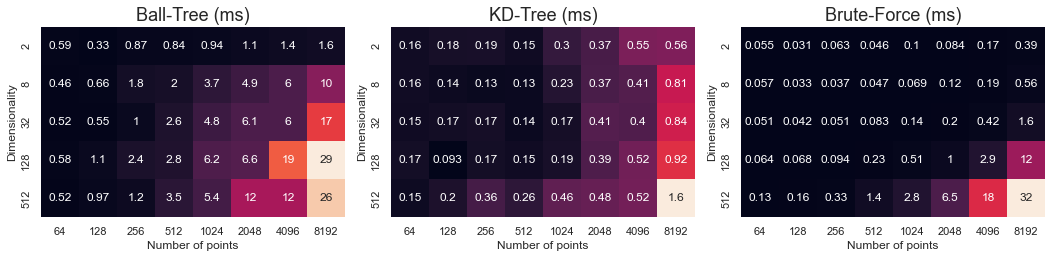

In [11]:
dummy_features = False
fig, ax = plt.subplots(1, 3, figsize=(18, 10), gridspec_kw={'wspace': 0.15})
ax1 = test_across(BallTreeOptimizer, ns, 'ds', ds, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[0])
ax1.set_title('Ball-Tree (ms)', size=18)
ax1 = test_across(KDTreeOptimizer, ns, 'ds', ds, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[1])
ax1.set_title('KD-Tree (ms)', size=18)
ax1 = test_across(LinearOptimizer, ns, 'ds', ds, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[2])
ax1.set_title('Brute-Force (ms)', size=18);
fig.savefig('figures/variable=dimension;datset=1;chart=heatmap.png');

Dataset type 2

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

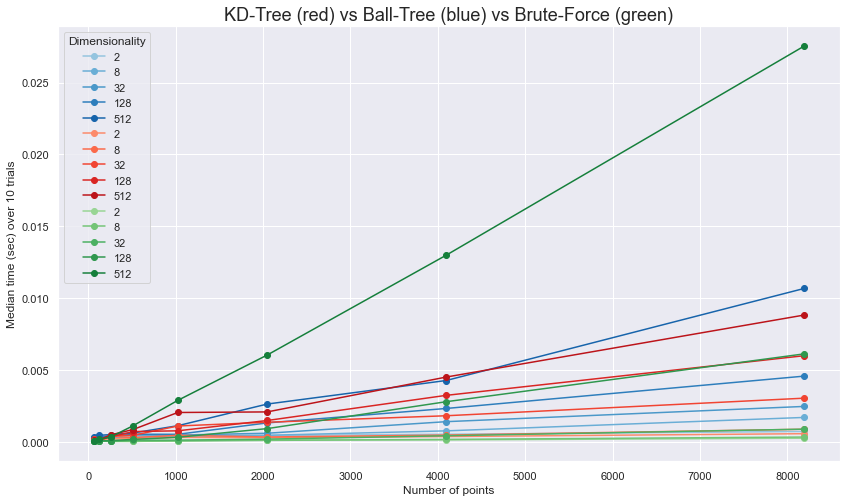

In [12]:
dummy_features = True
ax = test_across(BallTreeOptimizer, ns, 'ds', ds, var_default, dummy_features=dummy_features, cmap='Blues')
ax = test_across(KDTreeOptimizer, ns, 'ds', ds, var_default, dummy_features=dummy_features, ax=ax, cmap='Reds')
test_across(LinearOptimizer, ns, 'ds', ds, var_default, dummy_features=dummy_features, ax=ax, cmap='Greens')
ax.set_title(f'KD-Tree (red) vs Ball-Tree (blue) vs Brute-Force (green)', size=18);
plt.savefig('figures/variable=dimension;datset=2;chart=line.png');

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

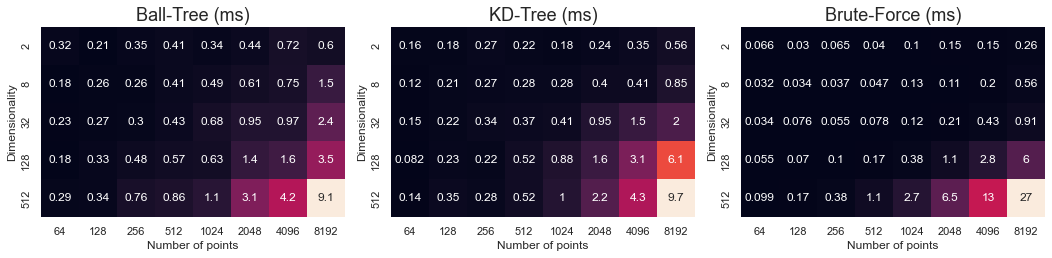

In [13]:
dummy_features = True
fig, ax = plt.subplots(1, 3, figsize=(18, 10), gridspec_kw={'wspace': 0.15})
ax1 = test_across(BallTreeOptimizer, ns, 'ds', ds, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[0])
ax1.set_title('Ball-Tree (ms)', size=18)
ax1 = test_across(KDTreeOptimizer, ns, 'ds', ds, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[1])
ax1.set_title('KD-Tree (ms)', size=18)
ax1 = test_across(LinearOptimizer, ns, 'ds', ds, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[2])
ax1.set_title('Brute-Force (ms)', size=18);
fig.savefig('figures/variable=dimension;datset=2;chart=heatmap.png');

### Test number of neighbors impact

In [14]:
# tabulation values
ks = np.logspace(start=0, stop=8, num=8-0+1, base=2, dtype='int')[::2]
ks

array([  1,   4,  16,  64, 256])

Dataset type 1

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

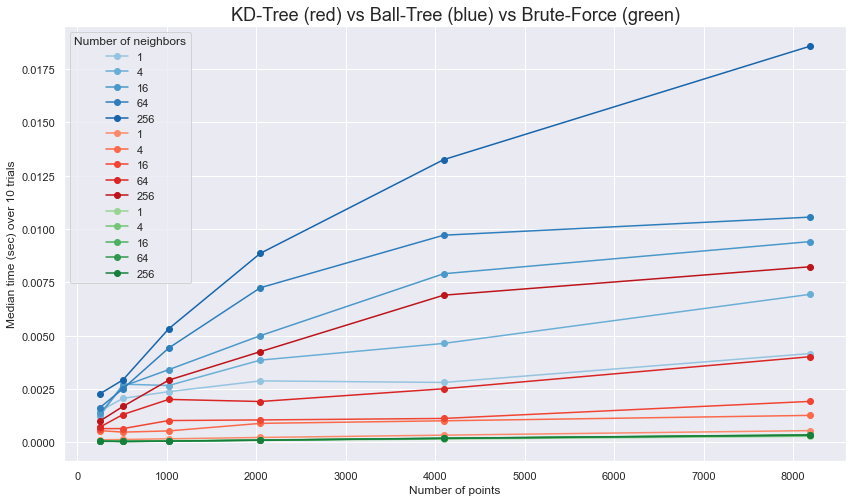

In [15]:
dummy_features = False
ax = test_across(BallTreeOptimizer, ns[2:], 'ks', ks, var_default, dummy_features=dummy_features, cmap='Blues')
ax = test_across(KDTreeOptimizer, ns[2:], 'ks', ks, var_default, dummy_features=dummy_features, ax=ax, cmap='Reds')
test_across(LinearOptimizer, ns[2:], 'ks', ks, var_default, dummy_features=dummy_features, ax=ax, cmap='Greens')
ax.set_title(f'KD-Tree (red) vs Ball-Tree (blue) vs Brute-Force (green)', size=18);
plt.savefig('figures/variable=num_neighbors;datset=1;chart=line.png');

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

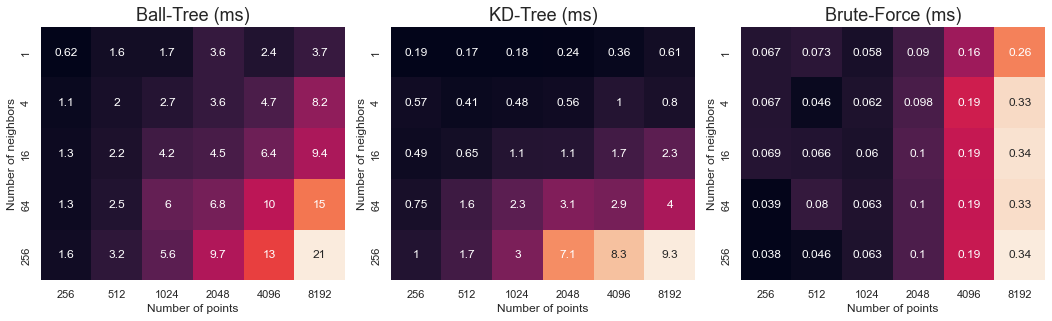

In [16]:
dummy_features = False
fig, ax = plt.subplots(1, 3, figsize=(18, 10), gridspec_kw={'wspace': 0.15})
ax1 = test_across(BallTreeOptimizer, ns[2:], 'ks', ks, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[0])
ax1.set_title('Ball-Tree (ms)', size=18)
ax1 = test_across(KDTreeOptimizer, ns[2:], 'ks', ks, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[1])
ax1.set_title('KD-Tree (ms)', size=18)
ax1 = test_across(LinearOptimizer, ns[2:], 'ks', ks, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[2])
ax1.set_title('Brute-Force (ms)', size=18);
fig.savefig('figures/variable=num_neighbors;datset=1;chart=heatmap.png');

Dataset type 2

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

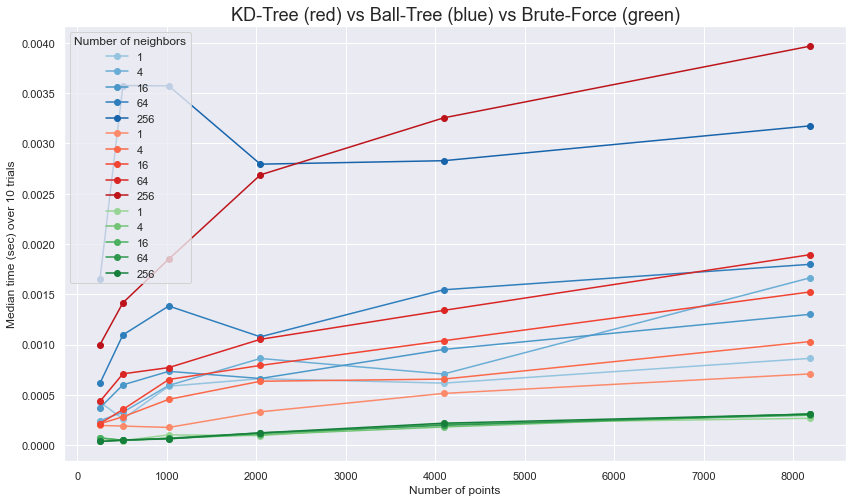

In [17]:
dummy_features = True
ax = test_across(BallTreeOptimizer, ns[2:], 'ks', ks, var_default, dummy_features=dummy_features, cmap='Blues')
ax = test_across(KDTreeOptimizer, ns[2:], 'ks', ks, var_default, dummy_features=dummy_features, ax=ax, cmap='Reds')
test_across(LinearOptimizer, ns[2:], 'ks', ks, var_default, dummy_features=dummy_features, ax=ax, cmap='Greens')
ax.set_title(f'KD-Tree (red) vs Ball-Tree (blue) vs Brute-Force (green)', size=18);
plt.savefig('figures/variable=num_neighbors;datset=2;chart=line.png');

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

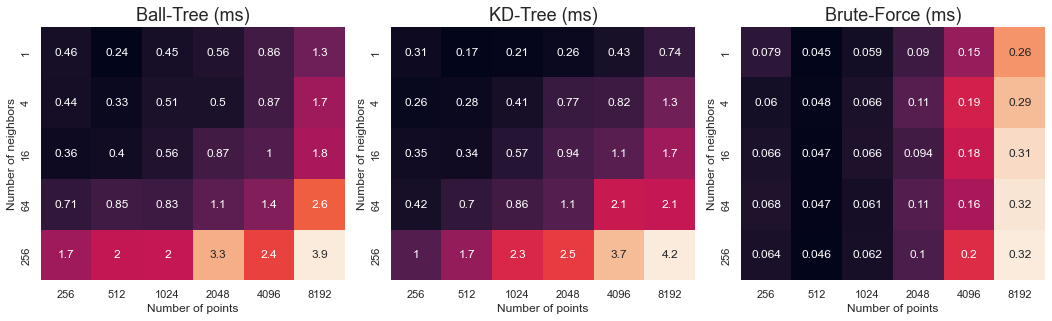

In [18]:
dummy_features = True
fig, ax = plt.subplots(1, 3, figsize=(18, 10), gridspec_kw={'wspace': 0.15})
ax1 = test_across(BallTreeOptimizer, ns[2:], 'ks', ks, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[0])
ax1.set_title('Ball-Tree (ms)', size=18)
ax1 = test_across(KDTreeOptimizer, ns[2:], 'ks', ks, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[1])
ax1.set_title('KD-Tree (ms)', size=18)
ax1 = test_across(LinearOptimizer, ns[2:], 'ks', ks, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[2])
ax1.set_title('Brute-Force (ms)', size=18);
fig.savefig('figures/variable=num_neighbors;datset=2;chart=heatmap.png');

### Test leaf size impact

In [19]:
# tabulation values
ls = [1, 3, 5 ,7, 10, 15, 30, 50, 100]
ls

[1, 3, 5, 7, 10, 15, 30, 50, 100]

Dataset type 1

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

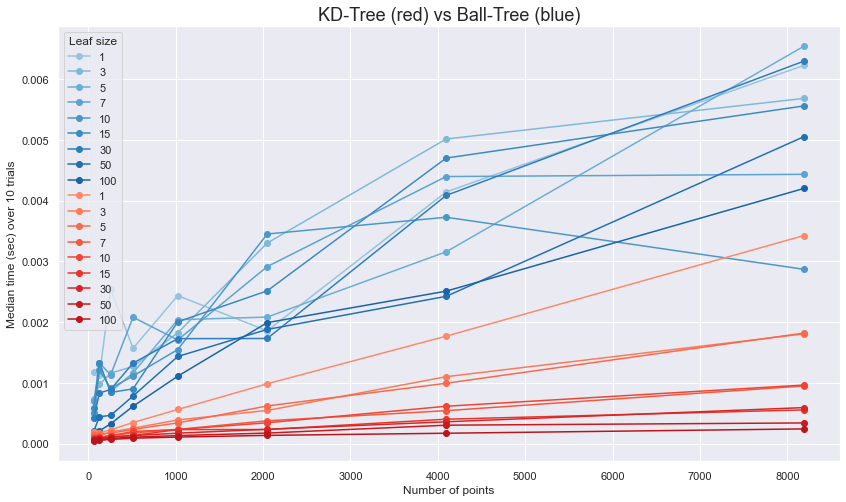

In [20]:
dummy_features = False
ax = test_across(BallTreeOptimizer, ns, 'ls', ls, var_default, dummy_features=dummy_features, cmap='Blues')
ax = test_across(KDTreeOptimizer, ns, 'ls', ls, var_default, dummy_features=dummy_features, ax=ax, cmap='Reds')
ax.set_title(f'KD-Tree (red) vs Ball-Tree (blue)', size=18);
plt.savefig('figures/variable=leaf_size;datset=1;chart=line.png');

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

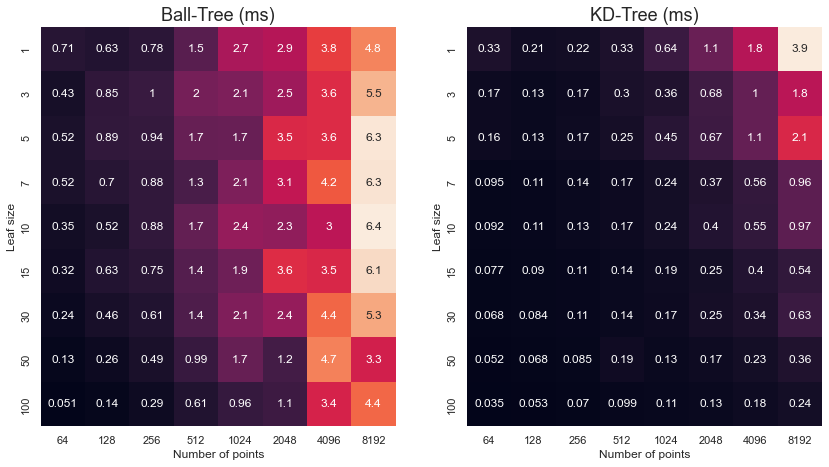

In [21]:
dummy_features = False
fig, ax = plt.subplots(1, 2, figsize=(14, 10))
ax1 = test_across(BallTreeOptimizer, ns, 'ls', ls, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[0])
ax1.set_title('Ball-Tree (ms)', size=18)
ax1 = test_across(KDTreeOptimizer, ns, 'ls', ls, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[1])
ax1.set_title('KD-Tree (ms)', size=18);
fig.savefig('figures/variable=leaf_size;datset=1;chart=heatmap.png');

Dataset type 2

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

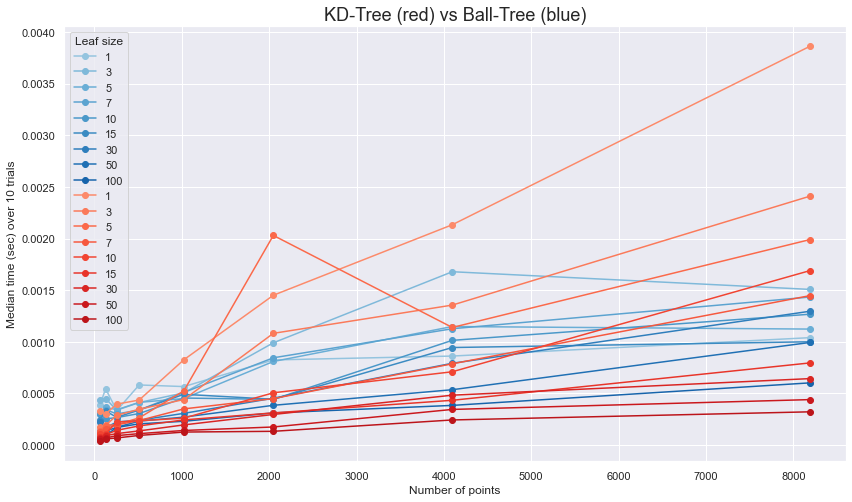

In [22]:
dummy_features = True
ax = test_across(BallTreeOptimizer, ns, 'ls', ls, var_default, dummy_features=dummy_features, cmap='Blues')
ax = test_across(KDTreeOptimizer, ns, 'ls', ls, var_default, dummy_features=dummy_features, ax=ax, cmap='Reds')
ax.set_title(f'KD-Tree (red) vs Ball-Tree (blue)', size=18);
plt.savefig('figures/variable=leaf_size;datset=2;chart=line.png');

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

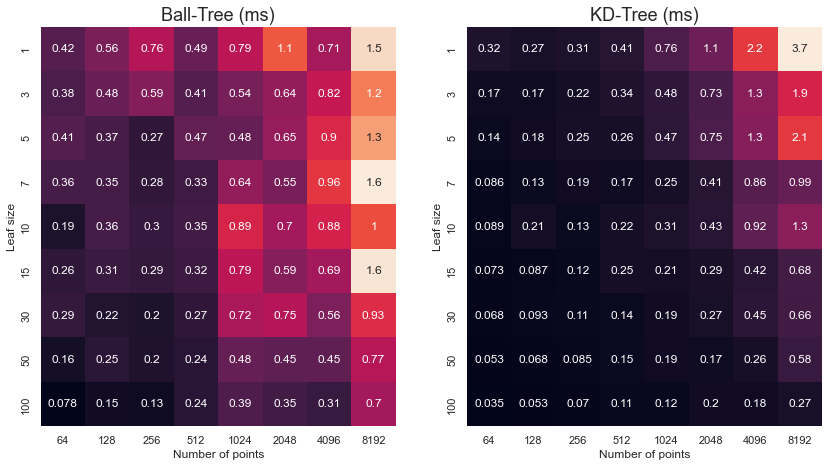

In [23]:
dummy_features = True
fig, ax = plt.subplots(1, 2, figsize=(14, 10))
ax1 = test_across(BallTreeOptimizer, ns, 'ls', ls, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[0])
ax1.set_title('Ball-Tree (ms)', size=18)
ax1 = test_across(KDTreeOptimizer, ns, 'ls', ls, var_default, dummy_features=dummy_features, style='heatmap', ax=ax[1])
ax1.set_title('KD-Tree (ms)', size=18);
fig.savefig('figures/variable=leaf_size;datset=2;chart=heatmap.png');